In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Load the data
sample_id = "IMMUNEX001"
adata = sc.read_10x_h5(f"/scratch/IMMUNEX/OUTPUT/Visium_NSCLC_{sample_id}/outs/binned_outputs/square_016um/filtered_feature_bc_matrix.h5")
adata.raw = adata
adata.uns['sample_id'] = sample_id
adata


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 170351 × 18536
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sample_id'

In [2]:
import pandas as pd

# Load coordinates from Space Ranger output (adjust path as needed)
parquet_path = f"/scratch/IMMUNEX/OUTPUT/Visium_NSCLC_{sample_id}/outs/binned_outputs/square_016um/spatial/tissue_positions.parquet"
coords = pd.read_parquet(parquet_path)
display(coords.head())

# Set barcode index if not done
coords.set_index("barcode", inplace=True)

# Join without suffix — no conflict now
adata.obs = adata.obs.join(coords, how="left")
display(adata.obs)

# Keep only bins with spatial coordinates
adata = adata[adata.obs["pxl_row_in_fullres"].notnull()].copy()

# Add to obsm
adata.obsm["spatial"] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values

adata.obs["library_id"] = "IMMUNEX001"
adata.uns["spatial"] = {
    "IMMUNEX001": {
        "images": {"hires": None},
        "scalefactors": {
            "tissue_hires_scalef": 1.0,
            "spot_diameter_fullres": 1.0
        }
    }
}

adata.obs


,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
0,s_016um_00000_00000-1,1,0,0,43228.415744,85601.051037
1,s_016um_00000_00001-1,1,0,1,43229.061228,85531.090936
2,s_016um_00000_00002-1,1,0,2,43229.706713,85461.130844
3,s_016um_00000_00003-1,1,0,3,43230.352197,85391.170762
4,s_016um_00000_00004-1,1,0,4,43230.997681,85321.210689


,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
s_016um_00107_00066-1,1,107,66,50756.729258,81052.559994
s_016um_00158_00414-1,1,158,414,54549.075128,56739.865815
s_016um_00126_00213-1,1,126,213,52180.773160,70780.782226
s_016um_00290_00411-1,1,290,411,63781.787941,57034.525366
s_016um_00082_00292-1,1,82,292,49153.513113,65225.808212
...,...,...,...,...,...
s_016um_00001_00157-1,1,1,157,43399.714879,74618.074287
s_016um_00404_00257-1,1,404,257,71658.151605,67881.334555
s_016um_00412_00400-1,1,412,400,72309.865957,57882.426588
s_016um_00361_00190-1,1,361,190,68606.686039,72540.958498


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,library_id
s_016um_00107_00066-1,1,107,66,50756.729258,81052.559994,IMMUNEX001
s_016um_00158_00414-1,1,158,414,54549.075128,56739.865815,IMMUNEX001
s_016um_00126_00213-1,1,126,213,52180.773160,70780.782226,IMMUNEX001
s_016um_00290_00411-1,1,290,411,63781.787941,57034.525366,IMMUNEX001
s_016um_00082_00292-1,1,82,292,49153.513113,65225.808212,IMMUNEX001
...,...,...,...,...,...,...
s_016um_00001_00157-1,1,1,157,43399.714879,74618.074287,IMMUNEX001
s_016um_00404_00257-1,1,404,257,71658.151605,67881.334555,IMMUNEX001
s_016um_00412_00400-1,1,412,400,72309.865957,57882.426588,IMMUNEX001
s_016um_00361_00190-1,1,361,190,68606.686039,72540.958498,IMMUNEX001


In [3]:

tls_annotation = pd.read_csv('/scratch/IMMUNEX/data/TLS_ANNOTATIONS/TLSIMMUNEX001.csv')
tls_annotation.columns = ['barcode_8um','TLS']
tls_annotation[['row_8', 'col_8']] = tls_annotation['barcode_8um'].str.extract(r's_008um_(\d+)_(\d+)', expand=True).astype(int)

# Make sure your 16µm adata.obs index matches the tls_annotation index format
tls_annotation['row_16'] = tls_annotation['row_8'] // 2
tls_annotation['col_16'] = tls_annotation['col_8'] // 2
tls_annotation['barcode_16um'] = tls_annotation.apply(
    lambda x: f"s_016um_{x['row_16']:05d}_{x['col_16']:05d}-1", axis=1
)

# Build mapping from barcode to TLS
tls_dict = tls_annotation.set_index('barcode_16um')["TLS"].to_dict()

# Assign TLS to adata.obs using matching barcodes
adata.obs["TLS"] = adata.obs_names.map(tls_dict).fillna('Not_TLS')

adata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,library_id,TLS
s_016um_00107_00066-1,1,107,66,50756.729258,81052.559994,IMMUNEX001,Not_TLS
s_016um_00158_00414-1,1,158,414,54549.075128,56739.865815,IMMUNEX001,Not_TLS
s_016um_00126_00213-1,1,126,213,52180.773160,70780.782226,IMMUNEX001,Not_TLS
s_016um_00290_00411-1,1,290,411,63781.787941,57034.525366,IMMUNEX001,Not_TLS
s_016um_00082_00292-1,1,82,292,49153.513113,65225.808212,IMMUNEX001,Not_TLS
...,...,...,...,...,...,...,...
s_016um_00001_00157-1,1,1,157,43399.714879,74618.074287,IMMUNEX001,Not_TLS
s_016um_00404_00257-1,1,404,257,71658.151605,67881.334555,IMMUNEX001,Not_TLS
s_016um_00412_00400-1,1,412,400,72309.865957,57882.426588,IMMUNEX001,Not_TLS
s_016um_00361_00190-1,1,361,190,68606.686039,72540.958498,IMMUNEX001,Not_TLS


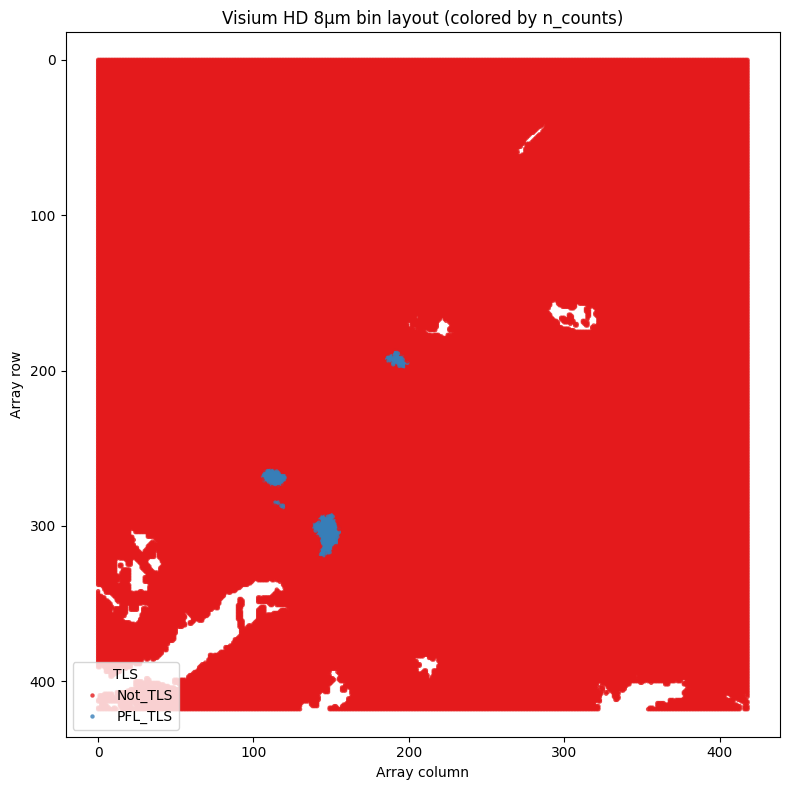

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
df = adata.obs.reset_index()

plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=df,
    x="array_col",
    y="array_row",
    hue="TLS",
    palette="Set1",
    s=10,
    linewidth=0,
    alpha=0.8
)

plt.gca().invert_yaxis()
plt.axis("equal")
plt.title("Visium HD 8µm bin layout (colored by n_counts)")
plt.xlabel("Array column")
plt.ylabel("Array row")
plt.tight_layout()
plt.show()


In [5]:
# Mitochondrial genes
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)


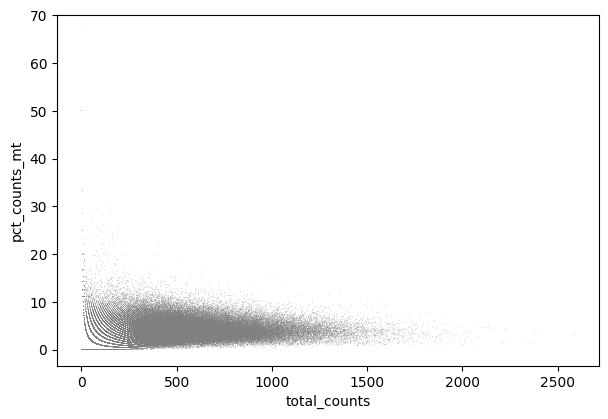

In [6]:
# # Plot QC
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


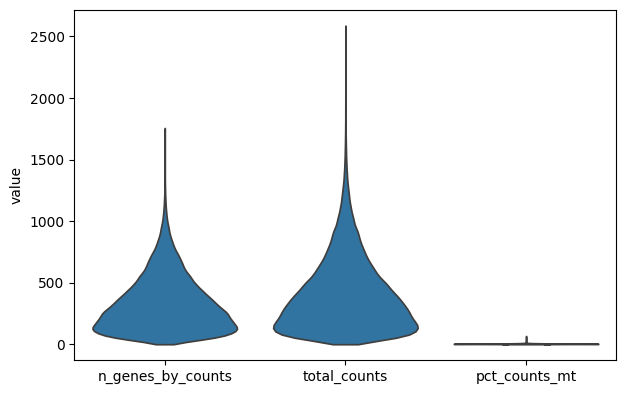

In [8]:
adata.var_names_make_unique()
adata.raw = adata.copy()
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=1, multi_panel=False, stripplot=False )


In [9]:
adata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,library_id,TLS,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
s_016um_00107_00066-1,1,107,66,50756.729258,81052.559994,IMMUNEX001,Not_TLS,684,6.529419,850.0,6.746412,21.411765,31.294118,43.058824,78.352941,55.0,4.025352,6.470589
s_016um_00158_00414-1,1,158,414,54549.075128,56739.865815,IMMUNEX001,Not_TLS,145,4.983607,156.0,5.056246,39.102564,71.153846,100.000000,100.000000,2.0,1.098612,1.282051
s_016um_00126_00213-1,1,126,213,52180.773160,70780.782226,IMMUNEX001,Not_TLS,187,5.236442,437.0,6.082219,68.649886,80.091533,100.000000,100.000000,6.0,1.945910,1.372998
s_016um_00290_00411-1,1,290,411,63781.787941,57034.525366,IMMUNEX001,Not_TLS,1027,6.935370,1309.0,7.177783,17.035905,24.828113,36.822002,59.740260,59.0,4.094345,4.507257
s_016um_00082_00292-1,1,82,292,49153.513113,65225.808212,IMMUNEX001,Not_TLS,492,6.200509,573.0,6.352629,22.862129,31.588133,49.040140,100.000000,28.0,3.367296,4.886562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_016um_00001_00157-1,1,1,157,43399.714879,74618.074287,IMMUNEX001,Not_TLS,178,5.187386,220.0,5.398163,41.818182,64.545455,100.000000,100.000000,10.0,2.397895,4.545455
s_016um_00404_00257-1,1,404,257,71658.151605,67881.334555,IMMUNEX001,Not_TLS,86,4.465908,95.0,4.564348,62.105263,100.000000,100.000000,100.000000,3.0,1.386294,3.157895
s_016um_00412_00400-1,1,412,400,72309.865957,57882.426588,IMMUNEX001,Not_TLS,631,6.448889,1021.0,6.929517,40.254652,47.992165,57.786484,87.169442,13.0,2.639057,1.273261
s_016um_00361_00190-1,1,361,190,68606.686039,72540.958498,IMMUNEX001,Not_TLS,12,2.564949,12.0,2.564949,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


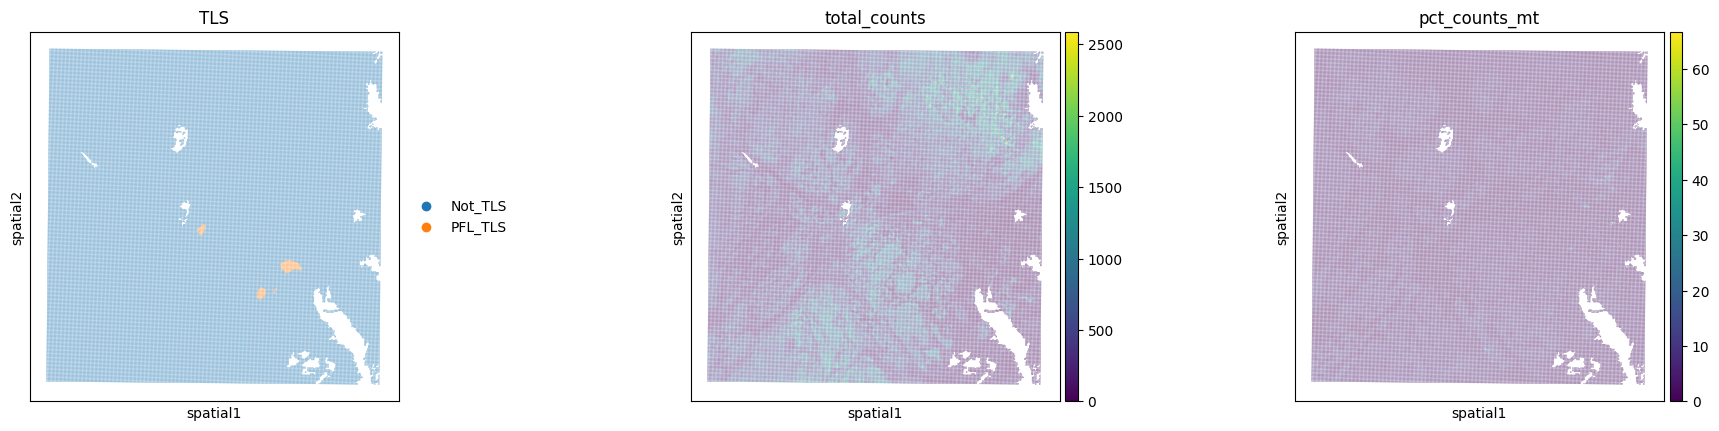

In [10]:
sc.pl.spatial(
    adata,
    color=["TLS", "total_counts", "pct_counts_mt"],
    size=50,
    cmap="viridis",  # or specify list of colormaps for each
    ncols=3,         # number of panels per row
    show=True
)


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


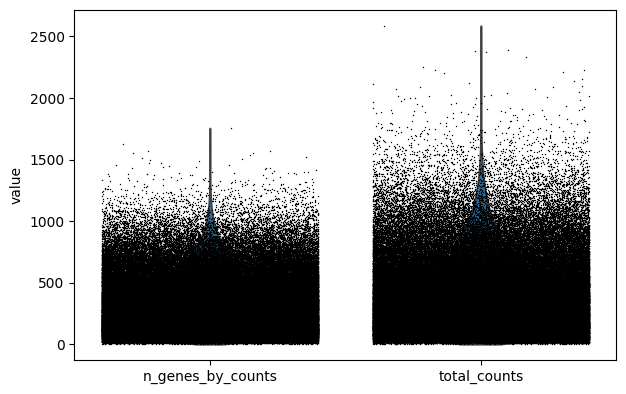

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


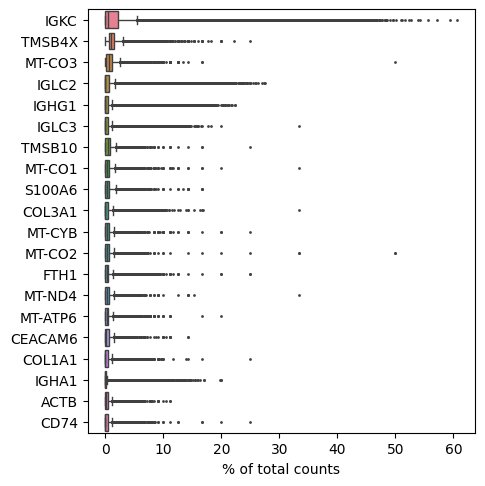

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


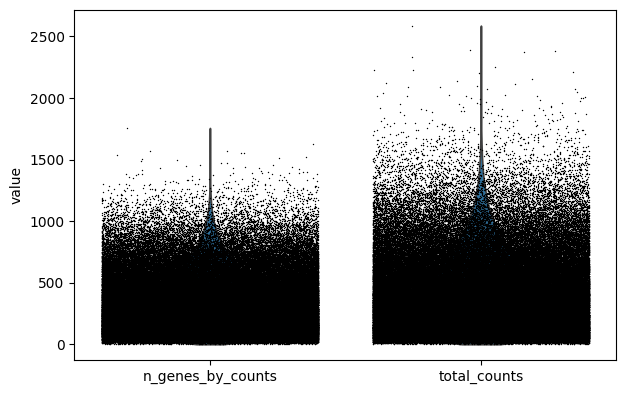

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


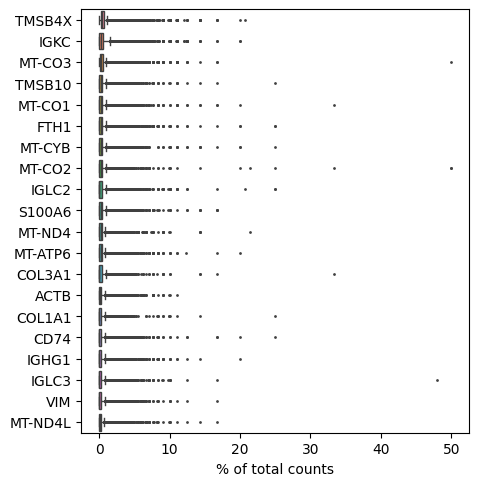

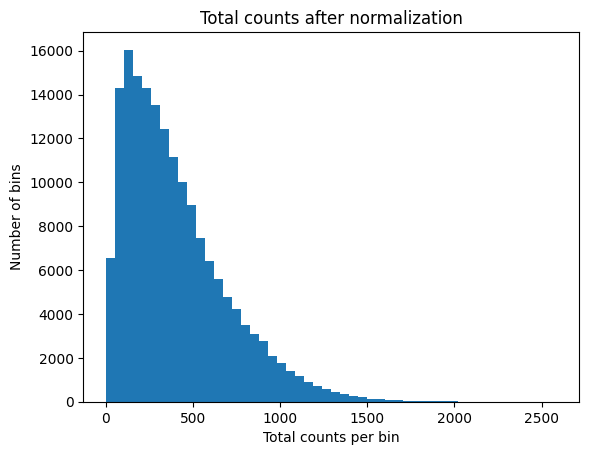

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


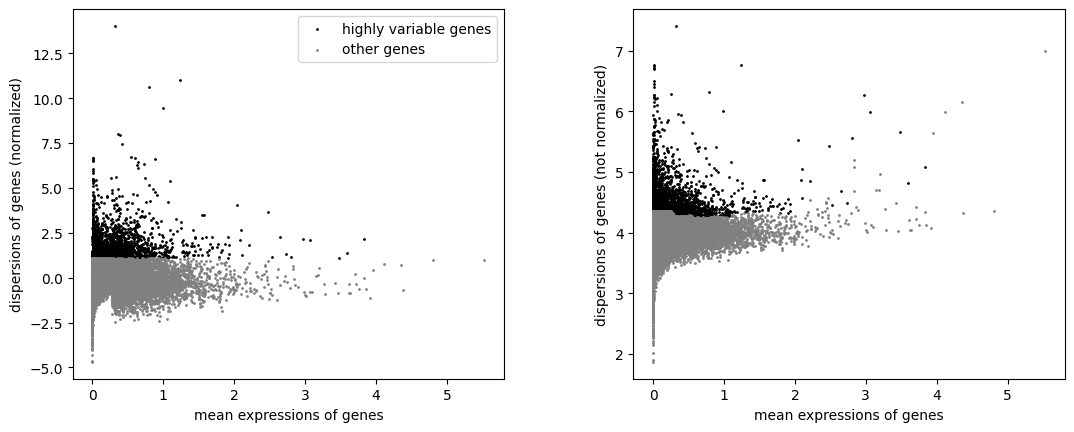

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


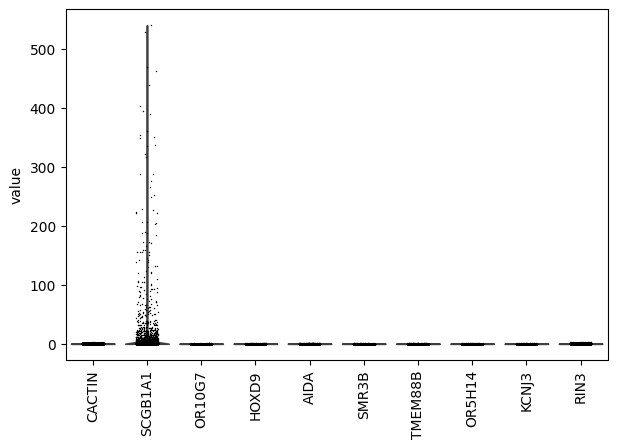

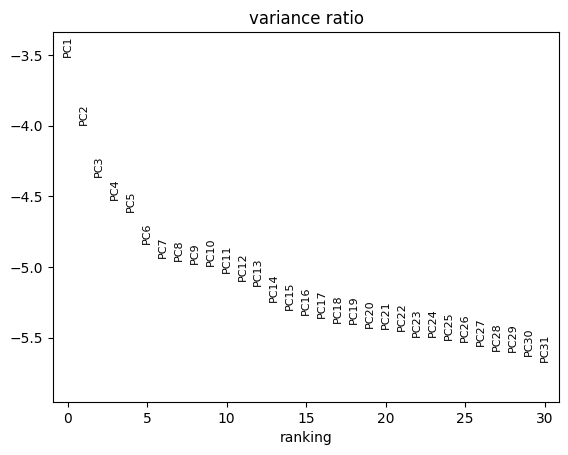

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------
# 🔍 Step 1: Before Normalization
# Plot total counts and gene counts
sc.pl.violin(adata, keys=['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=False)
sc.pl.highest_expr_genes(adata, n_top=20)

# ------------------------------------------
# ✅ Step 2: Normalize and log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 🔍 After normalization
sc.pl.violin(adata, keys=['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=False)
sc.pl.highest_expr_genes(adata, n_top=20, show=True)

# Optional: histogram of total counts after normalization
plt.figure()
plt.hist(adata.obs['total_counts'], bins=50)
plt.xlabel("Total counts per bin")
plt.ylabel("Number of bins")
plt.title("Total counts after normalization")
plt.show()

# ------------------------------------------
# ✅ Step 3: Highly Variable Genes
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

# 🔍 Visualize expression of top HVGs
top_hvg_names = adata.var[adata.var.highly_variable].sort_values("dispersions", ascending=False).index[:10]
sc.pl.violin(adata, keys=top_hvg_names.tolist(), jitter=0.2, rotation=90)

# Keep only HVGs
adata = adata[:, adata.var.highly_variable].copy()

# ------------------------------------------
# ✅ Step 4: PCA
# (Optional scaling before PCA — comment out if not desired)
# sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

# 🔍 Visualize PCA variance explained
sc.pl.pca_variance_ratio(adata, log=True)


In [22]:
import time
import scanpy as sc

sc.settings.verbosity = 3  # Show progress

# Step 1: Neighbors
start = time.time()
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=12)
end = time.time()
print(f"\n✅ Neighbors computed in {end - start:.2f} seconds")

# Step 2: Leiden clustering
start = time.time()
sc.tl.leiden(adata, resolution=1)
end = time.time()
print(f"✅ Leiden clustering completed in {end - start:.2f} seconds")

# Show object summary
adata


computing neighbors
    using 'X_pca' with n_pcs = 12
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)

✅ Neighbors computed in 29.51 seconds
running Leiden clustering
    finished: found 69 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:43)
✅ Leiden clustering completed in 163.69 seconds


AnnData object with n_obs × n_vars = 170351 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'library_id', 'TLS', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_.1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_id', 'spatial', 'TLS_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

running Leiden clustering
    finished: found 20 clusters and added
    'leiden_.1', the cluster labels (adata.obs, categorical) (0:01:42)
✅ Leiden clustering completed in 102.79 seconds
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:17)


/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


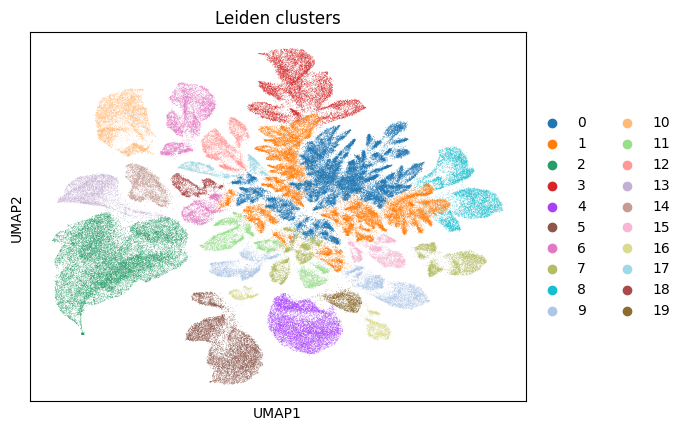

In [34]:
# Step 2: Leiden clustering
start = time.time()
sc.tl.leiden(adata, resolution=.1, key_added ='leiden_.1')
end = time.time()
print(f"✅ Leiden clustering completed in {end - start:.2f} seconds")

sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=42)
# Visualize clustering
sc.pl.umap(adata, color=["leiden_.1"], title="Leiden clusters")

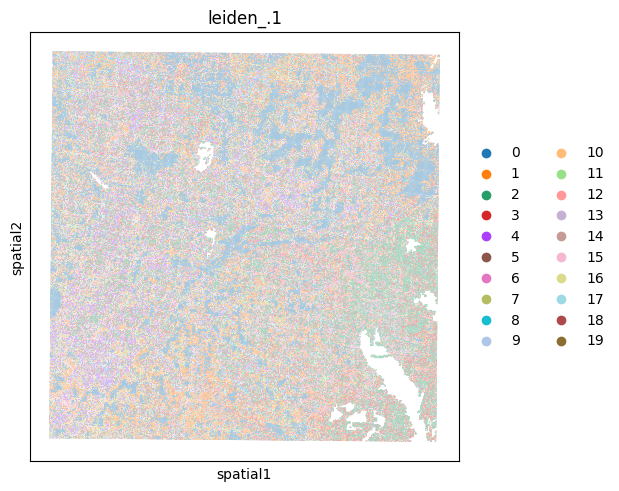

In [35]:
sq.pl.spatial_scatter(adata, color=['leiden_.1'], size=50, img=False)

/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


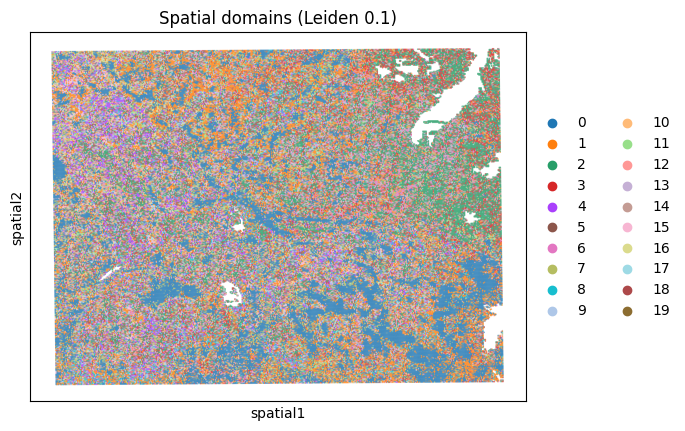

In [36]:
# Assuming spatial coordinates are in `adata.obsm["spatial"]`
sc.pl.embedding(
    adata,
    basis="spatial",
    color="leiden_.1",
    size=5,
    title="Spatial domains (Leiden 0.1)",
    alpha=0.6
)


In [37]:
adata

AnnData object with n_obs × n_vars = 170351 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'library_id', 'TLS', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_.1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_id', 'spatial', 'TLS_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_.1_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [40]:
import sys
sys.path.append("../../../../mounim/Banksy_py")  # Change to your actual path
from banksy_utils.load_data import load_adata, display_adata


In [41]:
from banksy.initialize_banksy import initialize_banksy
from banksy.embed_banksy import generate_banksy_matrix
from banksy.cluster_methods import run_Leiden_partition
from banksy.plot_banksy import plot_results


In [ ]:

coord_keys = ("array_col", "array_row", "spatial")
k_geom = 6
max_m = 1
nbr_weight_decay = "scaled_gaussian"
resolutions = [0.5,0.7,1,1.5]
pca_dims = [10,20,50,100,250]
lambda_list = [0.2,0.6,1]

banksy_dict = initialize_banksy(
    adata,
    coord_keys,
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=True,
)

from banksy.embed_banksy import generate_banksy_matrix
banksy_dict, banksy_matrix = generate_banksy_matrix(adata, banksy_dict, lambda_list, max_m)
from banksy_utils.umap_pca import pca_umap
pca_umap(banksy_dict, pca_dims=pca_dims, add_umap=True)

from banksy.cluster_methods import run_Leiden_partition
from banksy.plot_banksy import plot_results

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions=resolutions,
    num_nn=50,
    num_iterations=-1,
    partition_seed=1234,
    match_labels=True,
)

weights_graph = banksy_dict['scaled_gaussian']['weights'][0]

plot_results(
    results_df,
    weights_graph,
    c_map="tab20",
    match_labels=True,
    coord_keys=coord_keys,
    max_num_labels=max_num_labels,
    save_path="results/banksy_output",
    save_fig=True,
)



Median distance to closest cell = 69.96177545515002

---- Ran median_dist_to_nearest_neighbour in 0.51 s ----

---- Ran generate_spatial_distance_graph in 0.62 s ----

---- Ran row_normalize in 0.38 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 3.27 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 69.96345877070154, mode = 69.95913054394481

---- Ran plot_edge_histogram in 0.04 s ----


Edge weights (weights between cells): median = 0.2111529294837205, mode = 0.20867822670381803

---- Ran plot_edge_histogram in 0.04 s ----

---- Ran generate_spatial_distance_graph in 0.84 s ----

---- Ran theta_from_spatial_graph in 0.85 s ----

---- Ran row_normalize in 0.38 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 4.41 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 98.94223544198879, mode = 69.95913054394481

---- Ran plot_edge_histogram in 0.06 s ----



/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/numpy/lib/histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6857: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16
/home/mounim/miniconda3/envs/spatial_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)



Edge weights (weights between cells): median = (-0.0002804436537811035+0.03048800199334869j), mode = -0.0002424590376932101

---- Ran plot_edge_histogram in 0.10 s ----

----- Plotting Weights Graph -----
Maximum weight: 0.33056851670822285

---- Ran plot_graph_weights in 8.05 s ----

Maximum weight: (0.1848963043001367+0.0017008705682823634j)

---- Ran plot_graph_weights in 14.17 s ----

----- Plotting theta Graph -----
Runtime May-25-2025-18-48

2000 genes to be analysed:
Gene List:
Index(['TTLL10', 'PUSL1', 'MXRA8', 'TMEM88B', 'ATAD3A', 'SLC35E2B', 'DFFB',
       'AJAP1', 'RERE', 'PIK3CD',
       ...
       'MAGEA12', 'MAGEA6', 'ZNF185', 'ZFP92', 'HAUS7', 'DUSP9', 'SRPK3',
       'MPP1', 'ZFY', 'UTY'],
      dtype='object', length=2000)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <170351x170351 sparse matrix of type '<class 'numpy.float64'>'
	with 1022106 stored elements in Compressed Sparse Row format>, 1: <170351x1